# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 1. Deep Learning for Vision

**Upside down detector**: Train a model to detect if images are upside down

* Pick a dataset of natural images (we suggest looking at datasets on the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads))
* Synthetically turn some of images upside down. Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

### Hugging face

In [58]:
%pip install transformers datasets -q

### Essentials

In [59]:
import numpy as np

### Dowload dataset

In [60]:
from datasets import load_dataset
dataset = load_dataset('cifar10')
dataset

Reusing dataset cifar10 (/root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [61]:
im = dataset["train"]["img"][0]
np.array(im).shape

(32, 32, 3)

### Get model

In [62]:
id2label = {"0": "unflipped", "1": "flipped"}
label2id = {"unflipped": 0, "flipped": 1}

In [63]:
from transformers import ViTForImageClassification
from transformers import ViTConfig
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Used deivce :", device)

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.classifier = torch.nn.Linear(in_features=768, out_features = 2)

config = model.config.to_dict()
config["id2label"] = id2label
config["label2id"] = label2id

model.config = ViTConfig.from_dict(config) 

# model.eval()
model.train()
model.to(device);

Used deivce : cpu


In [64]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
encoding = feature_extractor(images=im, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values'])

#### Lets look at how the Features extractor works

In [65]:
encoding['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [66]:
encoding['pixel_values'].dtype

torch.float32

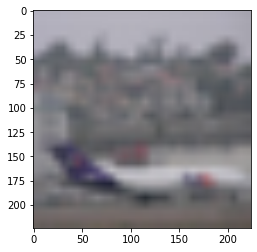

In [67]:
import torch
import matplotlib.pyplot as plt

a = torch.permute(encoding['pixel_values'], dims=[0,2,3,1]).reshape([224,224,3])*128 + 128
b = a.numpy().astype(np.uint8)
plt.imshow(b)

### Create our dataset

`P_FLIP` determines the proportion of flipped images.

Lets now take the convention :
```
Flipped images   => label = 1
Unflipped imahes => label = 0
```

In [68]:
P_FLIP = 0.5

In [69]:
from PIL import Image, ImageOps

def flip_img(img):
  return ImageOps.flip(img)

In [70]:
import random as rd

def flip_label(x, p=P_FLIP, **kwargs):
  if rd.random() > p:
    x["img"] = flip_img(x["img"])
    x["label"] = 1
  else :
    x["img"] = x["img"].convert('RGB') # Just to convert from PIL.PngImagePlugin.PngImageFile to PIL.Image.Image (otherwise, it will not be happy :D)
    x["label"] = 0
  # enc = feature_extractor(images=x["img"], return_tensors="pt")
  # x['pixel_values'] = enc['pixel_values']
  return x

def batch_flip_label(batch_x, **kwargs):
  # print(batch_x["label"])
  imgs = batch_x["img"]
  labels = batch_x["label"]
  batch_res = {"img" : [], "label": []}
  zipped_data = zip(imgs, labels)
  for i, data in enumerate(zipped_data):
    x = {"img" : data[0], "label" : data[1]}
    res = flip_label(x, **kwargs)
    batch_res["img"].append(res["img"])
    batch_res["label"].append(res["label"])
  return batch_res


In [71]:
rd.seed(41)
flipped_dataset = dataset.map(batch_flip_label, batch_size=64, batched=True, num_proc=2)

Loading cached processed dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-bf6816d95f99f2e5.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-6dd7f2875446ef03.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-58749583451f24d0.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-80641c308e3f3e3d.arrow


In [72]:
train, test = flipped_dataset["train"], flipped_dataset["test"]

In [73]:
# mm = train[:64]['img']
# enc = feature_extractor(images=mm, return_tensors="pt")
# enc["pixel_values"].shape

In [74]:
# model(enc['pixel_values'])

### Train

In [75]:
from torch.utils.data import DataLoader

d_train = DataLoader(train, batch_size = 64, num_workers=2)
# d_test = DataLoader

In [76]:
def batch_iterator(dataset=train, batch_size=16):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i : i + batch_size]

In [ ]:
from sklearn.metrics import accuracy_score

LR  = 0.00001
EPOCHS = 10

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

historical_accuracies_train = []
historical_accuracies_dev = []

for epoch in range(EPOCHS):
  print("*******************")
  print("Epoch :", epoch,"/", EPOCHS)
  # ----------------------------------- Train ---------------------------------- #
  all_train_predictions = []
  all_train_labels = []

  for batch in batch_iterator(train):
    model.train()

    imgs = batch["img"]
    pixel_values = feature_extractor(images=imgs, return_tensors="pt")["pixel_values"]
    labels = torch.tensor(batch["label"])

    proba = torch.nn.functional.softmax(model(pixel_values).logits, dim = -1)
    one_hot_labels = torch.nn.functional.one_hot(labels, 2)
    one_hot_labels = one_hot_labels.float()

    batch_loss = loss(proba, one_hot_labels)
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    all_train_predictions += torch.max(proba, -1)[1].tolist()
    all_train_labels += labels.tolist()

  train_acc = accuracy_score(all_train_labels, all_train_predictions)
  historical_accuracies_train.append(train_acc)
  print("train accuracy =", train_acc)

  # ----------------------------------- Eval ----------------------------------- #
  all_dev_predictions = []
  all_dev_labels = []
  for batch in batch_iterator(test):
    model.eval()

    imgs = batch["img"]
    pixel_values = feature_extractor(images=imgs, return_tensors="pt")["pixel_values"]
    labels = torch.tensor(batch["label"])
    
    with torch.no_grad():
      predictions = torch.max(model(pixel_values).logits, -1)[1]

    all_dev_labels += labels.tolist()
    all_dev_predictions += predictions.tolist()

    break
    
  dev_acc = accuracy_score(all_dev_labels, all_dev_predictions)
  historical_accuracies_dev.append(dev_acc)
  print("eval accuracy =", dev_acc)

*******************
Epoch : 0 / 10


In [ ]:
labels

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified images. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

# 2. Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model
* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* *Answer the following question*: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

# 3. Deep RL / Robotics

**RL for Classical Control:** Using any of the [classical control](https://github.com/openai/gym/blob/master/docs/environments.md#classic-control) environments from OpenAI's `gym`, implement a deep NN that learns an optimal policy which maximizes the reward of the environment.

* Describe the NN you implemented and the behavior you observe from the agent as the model converges (or diverges).
* Plot the reward as a function of steps (or Epochs).
Compare your results to a random agent.
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.
* (Optional) [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.


You may use any frameworks you like, but you must implement your NN on your own (no pre-defined/trained models like [`stable_baselines`](https://stable-baselines.readthedocs.io/en/master/)).

You may use any simulator other than `gym` _however_:
* The environment has to be similar to the classical control environments (or more complex like [`robosuite`](https://github.com/ARISE-Initiative/robosuite)).
* You cannot choose a game/Atari/text based environment. The purpose of this challenge is to demonstrate an understanding of basic kinematic/dynamic systems.

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* (Optional) link to the model on Hugging Face Hub: 
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.

# 4. Theory / Linear Algebra 

**Implement Contrastive PCA** Read [this paper](https://www.nature.com/articles/s41467-018-04608-8) and implement contrastive PCA in Python.

* First, please discuss what kind of dataset this would make sense to use this method on
* Implement the method in Python (do not use previous implementations of the method if they already exist)
* Then create a synthetic dataset and apply the method to the synthetic data. Compare with standard PCA.


**Write up**: Discuss what kind of dataset it would make sense to use Contrastive PCA

In [ ]:
### WRITE YOUR CODE HERE

# 5. Systems

**Inference on the edge**: Measure the inference times in various computationally-constrained settings

* Pick a few different speech detection models (we suggest looking at models  on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads))
* Simulate different memory constraints and CPU allocations that are realistic for edge devices that might run such models, such as smart speakers or microcontrollers, and measure what is the average inference time of the models under these conditions 
* How does the inference time vary with (1) choice of model (2) available system memory (3) available CPU (4) size of input?

Are there any surprising discoveries? (Note that this coding challenge is fairly open-ended, so we will be considering the amount of effort invested in discovering something interesting here).

In [ ]:
### WRITE YOUR CODE HERE

**Write up**: What surprising discoveries do you see?